<a href="https://colab.research.google.com/github/HannaKi/Sentiment-analysis-with-IMDB-data/blob/main/Sentiment_analysis_with_IMDB_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to experiment with hyperparameter search using Grid Search and sklearn Pipeline.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import time
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout
from keras import optimizers
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import FunctionTransformer

## Load and inspect the data

The data is IMBD reviews made for Stanford University research project (https://www.aclweb.org/anthology/P11-1015/). To learn more about the data please visit the web page or read the README file printed below.

For my purposes the test data is bi enough and I will use it for training, valdating and testing the model.

In [ ]:
%%bash
wget -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
tar -xf aclImdb_v1.tar.gz

In [3]:
%%bash
cd aclImdb
cat README | head -1000

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a scor

In [4]:
%%bash
cd aclImdb/test/neg
for f in *txt; do echo $f>> /content/neg_file_names.txt; done # appends filenames to file

In [5]:
%%bash
cd aclImdb/test/pos
for f in *txt; do echo $f>> /content/pos_file_names.txt; done # appends filenames to file

In [6]:
def open_file_by_looping(path, file):
  f=open(file)
  filenames = f.readlines()
  reviews = []
  for filename in filenames:
    fname = path + filename
    fname =fname.rstrip()
    f = open(fname)
    review = f.readlines()
    # print(type(review))
    reviews.append(review) 
    f.close()
  f.close()
  flat_list = [item for sublist in reviews for item in sublist] # we have list of lists, it needs to be flattened
  return flat_list

neg_reviews = open_file_by_looping("aclImdb/test/neg/", "neg_file_names.txt")
print("Number of negative reviews:", len(neg_reviews))

pos_reviews = open_file_by_looping("aclImdb/test/pos/", "pos_file_names.txt")
print("Number of positive reviews:", len(pos_reviews))

reviews=neg_reviews+pos_reviews
len(reviews)

Number of negative reviews: 12500
Number of positive reviews: 12500


25000

Data quality affects the performance of all machine learning algorithms and neural networks. Poor data can not be improved even with a sophisticated algorithm. In this case our data is balanced (classes have equal 50 % share) and well behaving in many aspects.

This is seldom true in real life applications. In these cases data balance must be taken care of with for example stratification or giving different weigths to different classes. If data is grouped or datarecords are not independent, even more caution should be given to the training process since this might lead to test data "leaking" into training data and thus highly optimistic model performance measeures. 

For these reasons one should familiarize her with a new dataset before rushing into further steps of modeling. If it is discovered that the data is imbalanced, grouped etc. we can fix the issues uprising from the nature of the data before we feed it to the algorithm, or at least take it in account when analysing the results. 

In [7]:
reviews=neg_reviews+pos_reviews
len(reviews)

# make labels for the reviews:
labels = ['neg']*len(neg_reviews) + ['pos']*len(pos_reviews)
print(len(labels))

# make shuffled indices and shuffle both of labels and reviews with them
indices = list(range(len(labels)))
random.shuffle(indices)

labels = [labels[index] for index in indices]
reviews = [reviews[index] for index in indices]

for label, text in zip(labels[:10], reviews[:10]):
  print("label:", label, "\ntext:", text, "\n")

25000
label: neg 
text: Has anyone else noticed that this version is basically a scene-by-scene remake of the 1933 version, with some of the scenes taken out? It makes me think less of a film that does that, showing a definite want of creativity. In all fairness, I tend to be biased in favor of Katharine Hepburn, but this version of the film seems like cinematic plagiarism. The 1933 version was nice and sweet, though a little awkward in presentation and transition at times, and then this version took the script, the music, and even a fair amount of the scene blocking from the earlier version. I don't understand the point of making the film again when the method of remaking it was to basically redo George Cukor's film with everything the same except the people working on it. 

label: pos 
text: A very interesting plot of the film based on the novel "Waltz into Darkness" of the writer Cornell Woolrich. It is a drama rather than a film noir, which tries to send a message that love changes

In [8]:
# Remove HTML tags


pattern1=r"<br /><br />" 
reviews = [re.sub(pattern1, " ", item) for item in reviews]

for label, text in zip(labels[:10], reviews[:10]):
  print("label:", label, "\ntext:", text, "\n")

label: neg 
text: Has anyone else noticed that this version is basically a scene-by-scene remake of the 1933 version, with some of the scenes taken out? It makes me think less of a film that does that, showing a definite want of creativity. In all fairness, I tend to be biased in favor of Katharine Hepburn, but this version of the film seems like cinematic plagiarism. The 1933 version was nice and sweet, though a little awkward in presentation and transition at times, and then this version took the script, the music, and even a fair amount of the scene blocking from the earlier version. I don't understand the point of making the film again when the method of remaking it was to basically redo George Cukor's film with everything the same except the people working on it. 

label: pos 
text: A very interesting plot of the film based on the novel "Waltz into Darkness" of the writer Cornell Woolrich. It is a drama rather than a film noir, which tries to send a message that love changes your 

In [9]:
# s = r"\s\tWord"
# prog = re.compile(s)
# prog

# re.sub(some_regex, some_replacement.replace('\\', '\\\\'), input_string)

In [10]:
# import re
# pattern1=r"<br /><br />" # something fishy is going on with HTML tags. Get rid of them
# s = "\\'"
# print(s)
# # pattern2=re.escape(r"\'")
# # print("p2:", pattern2)
# pattern3 = s
# print(pattern3)
# # print(pattern3.replace('\\', '\\\\'))
# print(chr(39))

# fixed = re.sub(pattern3, chr(39), reviews[8])
# fixed_n = re.sub(pattern1, " ", fixed)
# fixed_n

## Train-Dev-Test split the data

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.33)

print(len(X_train), len(y_train))

for label, text in zip(y_train[:10], X_train[:10]):
  print("label:", label, "\ntext:", text, "\n")

16750 16750
label: pos 
text: I felt cheated out of knowing the whole story. While there could be a twist, this twist was so significant, that I felt betrayed. I believe it could have used a better writer who could weave all the elements of the story together better. The writer could have revealed more of the 'twists' throughout the movie, rather than all at once at the end. That aside, I believe that the actors did very well with what they had, particularly Matt Damon, who actually had a little character in his character, little quirks that weren't egotistic or like a smooth criminal who always knows what he is doing. The other main characters were their own separate entities who just happened to converse with one another. The cohesiveness of the group in Ocean's Eleven was gone. 

label: neg 
text: Now don't get me wrong, I love seeing half naked chicks wiggling around. It's part of the fun of a Moroccan restaurant: ogling the belly dancers. But it doesn't make much of a plot. My fir

## Preprocessing: Tfidf Vectorizer 

Since we are dealing with text data we need to transform it to format a basic SVM can handle. For that purpose I use sklearn TfidfVectorizer. 

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=50000)
fm_train = vectorizer.fit_transform(X_train)
fm_test = vectorizer.transform(X_test)

In [13]:
# input data size is limited by the vectorizer

print(f"We have {fm_train.shape[0]} rows and {fm_train.shape[1]} columns in the training data")
print(f"And {fm_test.shape[0]} rows and {fm_test.shape[1]} columns in the training data")


We have 16750 rows and 50000 columns in the training data
And 8250 rows and 50000 columns in the training data


In [14]:
# type of the input data is scipy.sparse.csr.csr_matrix
print(type(fm_train))

# What does it mean? It looks like this:
print(fm_train[0:2:])

# Each row of the sparse matrix contains the indices of the tfidf matrix 
#(for example (0, 12247) and the tfidf weight).
# The row index is the document index (the number of the review) and the column 
# index is for the token 

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 19149)	0.0992167195479343
  (0, 14993)	0.1600074301975623
  (0, 29632)	0.1302782985303928
  (0, 19580)	0.09199589365638809
  (0, 2929)	0.06439606350971956
  (0, 29823)	0.03404083356641864
  (0, 11371)	0.18630697660858034
  (0, 43526)	0.02320659273763631
  (0, 20011)	0.0958430234346515
  (0, 23328)	0.04094448417345909
  (0, 15457)	0.18887982576393136
  (0, 36611)	0.13084570628890424
  (0, 30341)	0.07121103101501734
  (0, 42927)	0.05008940481189398
  (0, 48127)	0.050550407010130714
  (0, 9653)	0.05680058014095944
  (0, 26387)	0.07806913559755978
  (0, 30087)	0.050779703724875246
  (0, 14015)	0.08585788901442588
  (0, 22698)	0.024397430663128016
  (0, 20249)	0.041623988044122325
  (0, 23813)	0.09670902396076592
  (0, 2377)	0.07180640948442756
  (0, 11906)	0.12529222327194778
  (0, 38511)	0.14799223424459568
  :	:
  (1, 2377)	0.04284990707141776
  (1, 25068)	0.046441925541656805
  (1, 20712)	0.024423972317116
  (1, 21758)	0.029512774836013816
  (

In [15]:
# Columns are mostly empty because most words in the vocabulary do not appear in every sentence
# This is why sparse format is used instead of dense:
print(fm_train[0:2].todense())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
# In the vectorizer vocabulary we have the original words as key value pairs, where the 
# word is the key and matrix index is the value:

for (idx, item) in enumerate(vectorizer.vocabulary_.items()):
  print("Key:", item[0], "\tValue:",item[1])
  if (idx==8):
    break

Key: felt 	Value: 16799
Key: cheated 	Value: 9757
Key: out 	Value: 30112
Key: of 	Value: 29677
Key: knowing 	Value: 23807
Key: the 	Value: 42903
Key: whole 	Value: 48395
Key: story 	Value: 40481
Key: while 	Value: 48276


## Finding the best model with GridSearch Cross Validation

The model can be trained by exploring the hyperparameters one by one or with nested for-loops. It will how ever become a frustrating task to keep up with the hyperparameter combinations and obtained performence values. A more systematic way to do this is by using GridSearch (GS). 

GridSearchCV allows us set grid (or multiple vectors) of hypermarameters to try with. The idea is to try and find a sweet spot (best performance measure) by adjusting the grid. K-fold CV also introduces a new hyperparameter, which affects the training results, namely the number of folds.

GS uses K-fold Cross Validation (CV) to find the best performing model. Depending on the algorithm and chosen parameters the data is "folded" (divided into subsets) n times and each of these folds is used once for testing while n-1 folds are used for training. Cross validation is also useful when the data set size is limited and we would like to "eat the cake and keep it".

For the task I have chosen Linear Support Vector Classifier. When classifying multiple classes and the number of classes in *n* LinearSVC implements “one-vs-the-rest” multi-class strategy, thus training *n* models ([Scikit-learn](https://scikit-learn.org/stable/modules/svm.html#svm-classification)). At prediction time all the classifers "vote", and item will be assigned to class with the lowest cost. Other possible models for text classification problem are for example K-Nearest-Neighbors and Multinomial Naive Bayes. Also classifiers can be compared with GS.

A simple pipeline is built for both the preprocessor (vectorizer) and the classifier so that we are able to find the best hyperparameters for both of them at once.

Sources:

[GridSearchCV documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

[GridSearchCV example 1](https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html) 

[GridSearchCV example 2](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html) 

[SVM documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

[GridSearchCV scoring parameters](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) 

#### TfidfVectorizer with SVM

In [18]:
costs = np.logspace(-1, 1, num=5, endpoint = False)

pipeline = Pipeline([
    ('vec', TfidfVectorizer()),
    ('clf', LinearSVC()),
])

parameters = {
    #'vec__binary': (True, False), # Previous runs revealed this does not seem to matter
    'vec__max_features': (10000, 30000),
    'vec__ngram_range': ((1, 1), (1, 2), (1, 3)),  
    'clf__C': (costs), 
}
# find the best parameters for both the feature extraction and the classifier
print("Running grid search...")
# n_jobs=-1: use as many cores as possible
# cv=3: three folds (this is kind of little but it speeds things up)
gridsearch = GridSearchCV(pipeline, parameters, cv=3, verbose=1, n_jobs=-1)
gridsearch.fit(X_train, y_train)
print("Grid search done!")
print()
print(f"Best score: {gridsearch.best_score_:0.2}")
print("Best of the observed hyperparameters:")
best_parameters = gridsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
      print(f"{param_name}: {best_parameters[param_name]}")

Running grid search...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 12.9min finished


Grid search done!

Best score: 0.9
Best of the observed hyperparameters:
clf__C: 0.6309573444801934
vec__max_features: 30000
vec__ngram_range: (1, 2)


So was the selected model clearly the best?

In [19]:
# set column visibility in pandas df
pd.set_option("max_colwidth", None)

# extract mean score for each parameter combination trained
means = gridsearch.cv_results_['mean_test_score'] 

GSCV_results = pd.DataFrame(list(zip(means, gridsearch.cv_results_['params'])), 
               columns =['Score', 'Parameters']) 
# sort by the score
GSCV_results.sort_values(by="Score", ascending=False, inplace=True)
print(GSCV_results.head(7))

       Score                                                                              Parameters
16  0.902269  {'clf__C': 0.6309573444801934, 'vec__max_features': 30000, 'vec__ngram_range': (1, 2)}
17  0.901552  {'clf__C': 0.6309573444801934, 'vec__max_features': 30000, 'vec__ngram_range': (1, 3)}
10  0.900060   {'clf__C': 0.251188643150958, 'vec__max_features': 30000, 'vec__ngram_range': (1, 2)}
22  0.899403   {'clf__C': 1.584893192461114, 'vec__max_features': 30000, 'vec__ngram_range': (1, 2)}
11  0.898388   {'clf__C': 0.251188643150958, 'vec__max_features': 30000, 'vec__ngram_range': (1, 3)}
23  0.895701   {'clf__C': 1.584893192461114, 'vec__max_features': 30000, 'vec__ngram_range': (1, 3)}
7   0.894687   {'clf__C': 0.251188643150958, 'vec__max_features': 10000, 'vec__ngram_range': (1, 2)}


Not! This seemd to be a tight race.

##### Performance evaluation

Test accuracy: 0.91



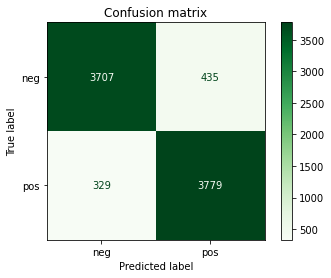

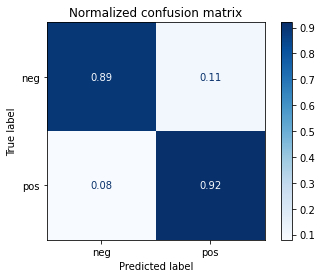

In [20]:
# classifier=grid_search.best_estimator_
# classifier.fit(feature_matrix_train, train_label)

predictions = gridsearch.predict(X_test)
acc = accuracy_score(y_test, predictions)
# conf = confusion_matrix(test_labels, predictions)

print(f"Test accuracy: {acc:0.2f}")
print()
# note here we have to feed in the test data not feature matrix since esitimator is a pipeline, not a classifier!
plot_confusion_matrix(gridsearch.best_estimator_, X_test, y_test, cmap='Greens', values_format='d')  
plt.title("Confusion matrix")
plt.show()

plot_confusion_matrix(gridsearch.best_estimator_, X_test, y_test, cmap='Blues', normalize='true')  
plt.title("Normalized confusion matrix")
plt.show()

In [21]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         neg       0.92      0.89      0.91      4142
         pos       0.90      0.92      0.91      4108

    accuracy                           0.91      8250
   macro avg       0.91      0.91      0.91      8250
weighted avg       0.91      0.91      0.91      8250



The model handled both of the classes well. This can be seen from the confusion matrix and from the classification report where precision and recall are in balance for both os the labels.

#### Simple Neural Network


In [22]:
# redo the split to overwrite old variables
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.33)

To build a NN we need to

1.   turn numpy vectors to tensors
2.   know the shape of input layer (number of features)
3.   know the shape of output layer (number of classes)

TfidfVectorizer gives the 2nd one and LabelEncoder (for example) the 3rd one. (or just len(set(train_labels))

In [23]:
# 1) np vectors to TF tensors

def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

Since vectorizer affects the shape of the NN, we do not optimize it as a part of the pipeline.

In [39]:
# 2) size of input 
vectorizer = TfidfVectorizer(max_features=100000)

ft_matrix = vectorizer.fit_transform(X_train)
ft_matrix.shape # so we need the second dimension for building the nn
input_size = ft_matrix.shape[1]
print("Size of input layer:", input_size)

Size of input layer: 63066


In [31]:
# 3) size_of_output_layer
# use encoded labels when fitting the model and for testing

label_encoder = LabelEncoder() #Turns class labels into integers
class_numbers_train = label_encoder.fit_transform(y_train)

print("class_numbers shape=", class_numbers_train.shape)
print("class labels", label_encoder.classes_) #this will let us translate back from indices to labels

output_size = len(label_encoder.classes_)
print("Size of output layer:", output_size)

class_numbers shape= (16750,)
class labels ['neg' 'pos']
Size of output layer: 2


In [44]:
def build_sequential_nn(input_size=100, output_size=2, hiddenlayer_size=200, drop_out= 0.3, learning_rate=0.001): 
  # let's make 200 default sixe of the hiddenlayer
  model = Sequential()
  model.add(Input(shape = (input_size, )))
  model.add(Dense(hiddenlayer_size, activation = "relu", ))
  model.add(Dropout(rate=drop_out)) # Dropout regularizer to avoid over fitting
  model.add(Dense(output_size, activation = "softmax"))
  model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
  return model

model = build_sequential_nn(input_size=input_size, output_size=output_size)
model.summary()

Model: "sequential_489"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_978 (Dense)            (None, 200)               12613400  
_________________________________________________________________
dropout_489 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_979 (Dense)            (None, 2)                 402       
Total params: 12,613,802
Trainable params: 12,613,802
Non-trainable params: 0
_________________________________________________________________


In [45]:
pipeline = Pipeline([
    ('trans', FunctionTransformer(convert_sparse_matrix_to_sparse_tensor)), # wrapper for custom function
    ('clf', KerasClassifier(build_fn=build_sequential_nn)), # wrapper for Keras model
])

parameters = {
    'clf__hiddenlayer_size': (200, 300), 
    'clf__input_size': ([input_size]), # GS sets ALL the params
    'clf__output_size': ([output_size]),
    'clf__batch_size': (64, 265),
    'clf__drop_out': (0.2, 0.4), # regularizer to avoid over fitting
    'clf__epochs': (2, 4), # do not use early stopping callback, number of epochs is best treated as a hyper parameter: https://stackoverflow.com/questions/48127550/early-stopping-with-keras-and-sklearn-gridsearchcv-cross-validation
    'clf__learning_rate': (0.001, 0.01) # 0.001 is default for Adam
}

t0=time.time()
print("Running grid search...")
gridsearch = GridSearchCV(pipeline, parameters, verbose=1, n_jobs=1)
gridsearch.fit(ft_matrix, class_numbers_train)
print()

print(f"Best score: {gridsearch.best_score_:0.2}")

print("Best of the observed hyperparameters:")
best_parameters = gridsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
      print(f"{param_name}: {best_parameters[param_name]}")

t1=time.time()

Running grid search...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/2
210/210 [==============================] - 1s 5ms/step - loss: 0.5054 - accuracy: 0.8178
Epoch 2/2
53/53 [==============================] - 0s 2ms/step - loss: 0.2370 - accuracy: 0.9012
Epoch 1/2
210/210 [==============================] - 2s 5ms/step - loss: 0.5092 - accuracy: 0.7994
Epoch 2/2
53/53 [==============================] - 0s 2ms/step - loss: 0.2397 - accuracy: 0.9048
Epoch 1/2
210/210 [==============================] - 1s 5ms/step - loss: 0.5076 - accuracy: 0.7879
Epoch 2/2
53/53 [==============================] - 0s 2ms/step - loss: 0.2540 - accuracy: 0.8964
Epoch 1/2
210/210 [==============================] - 1s 5ms/step - loss: 0.5088 - accuracy: 0.7881
Epoch 2/2
53/53 [==============================] - 0s 2ms/step - loss: 0.2513 - accuracy: 0.8955
Epoch 1/2
210/210 [==============================] - 1s 5ms/step - loss: 0.5114 - accuracy: 0.7611
Epoch 2/2
53/53 [==============================] - 0s 2ms/step - loss: 0.2361 - accuracy: 0.9000
Epoch 1/2
210/210 [=

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  9.7min finished


Epoch 1/2
262/262 [==============================] - 2s 5ms/step - loss: 0.4910 - accuracy: 0.7975
Epoch 2/2
262/262 [==============================] - 1s 5ms/step - loss: 0.1070 - accuracy: 0.9687

Best score: 0.9
Best of the observed hyperparameters:
clf__batch_size: 64
clf__drop_out: 0.4
clf__epochs: 2
clf__hiddenlayer_size: 200
clf__input_size: 63066
clf__learning_rate: 0.001
clf__output_size: 2


In [46]:
print(f"Time elapsed {(t1-t0)/60:0.3} minutes")

Time elapsed 9.72 minutes


In [47]:
means = gridsearch.cv_results_['mean_test_score'] 

GSCV_results = pd.DataFrame(list(zip(means, gridsearch.cv_results_['params'])), 
               columns =['Score', 'Parameters']) 
# sort by the score
GSCV_results.sort_values(by="Score", ascending=False, inplace=True)
print(GSCV_results.head(7))

       Score                                                                                                                                                                    Parameters
8   0.902567   {'clf__batch_size': 64, 'clf__drop_out': 0.4, 'clf__epochs': 2, 'clf__hiddenlayer_size': 200, 'clf__input_size': 63066, 'clf__learning_rate': 0.001, 'clf__output_size': 2}
28  0.902507  {'clf__batch_size': 265, 'clf__drop_out': 0.4, 'clf__epochs': 4, 'clf__hiddenlayer_size': 200, 'clf__input_size': 63066, 'clf__learning_rate': 0.001, 'clf__output_size': 2}
30  0.901791  {'clf__batch_size': 265, 'clf__drop_out': 0.4, 'clf__epochs': 4, 'clf__hiddenlayer_size': 300, 'clf__input_size': 63066, 'clf__learning_rate': 0.001, 'clf__output_size': 2}
26  0.901731  {'clf__batch_size': 265, 'clf__drop_out': 0.4, 'clf__epochs': 2, 'clf__hiddenlayer_size': 300, 'clf__input_size': 63066, 'clf__learning_rate': 0.001, 'clf__output_size': 2}
20  0.901254  {'clf__batch_size': 265, 'clf__drop_out': 0.2, 'clf

Accuracy scores are rather high from epoch to epoch excluding the first one. A more regularized model seems to be better, since models with less hidden layer neurons and higher drop out rate are ranked higher. Smaller learning rate dominates the bigger one. It must be noted, that differences between the model performances are minimal to say anything certain.

##### Performance evaluation

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test accuracy: 0.91



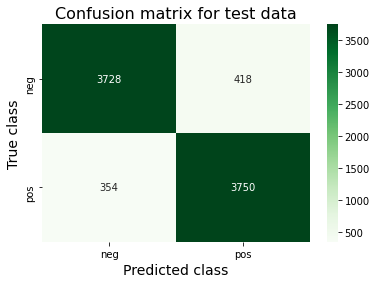

In [37]:
# prepare test data
ftm_test=vectorizer.transform(X_test) # model needs to be Sequential for predicting
class_numbers_test = label_encoder.transform(y_test)

# predict
raw_predictions = gridsearch.predict(ftm_test)
predictions=label_encoder.inverse_transform(raw_predictions)

# results
acc = accuracy_score(y_test, predictions)
print(f"Test accuracy: {acc:0.2f}")
print()
cf_mat = tf.math.confusion_matrix(
    class_numbers_test, raw_predictions, num_classes=None, weights=None
)

def plot_cf_matrix(mat):
  sns.heatmap(mat, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Greens')
  plt.title("Confusion matrix for test data", fontsize = 16)
  plt.ylabel("True class", fontsize = 14)
  plt.xlabel("Predicted class", fontsize = 14)

plot_cf_matrix(cf_mat)

In [38]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         neg       0.91      0.90      0.91      4146
         pos       0.90      0.91      0.91      4104

    accuracy                           0.91      8250
   macro avg       0.91      0.91      0.91      8250
weighted avg       0.91      0.91      0.91      8250



Performance is rather similar with simpler SVM.